# Transform

In [1]:
import numpy as np
import pandas as pd
import pywsra
import xarray as xr
import littlebuoybigwaves as buoy
from configure import read_stored_variable

## Setup

In [2]:
# %run 'nb0-datasets.ipynb'
%run -i configure.py

earl_ds = read_stored_variable('earl_ds')
fiona_ds = read_stored_variable('fiona_ds')
ian_ds = read_stored_variable('ian_ds')
julia_ds = read_stored_variable('julia_ds')
idalia_ds = read_stored_variable('idalia_ds')
lee_ds = read_stored_variable('lee_ds')
atomic_ds = read_stored_variable('atomic_ds')

earl_drifter_df = read_stored_variable('earl_drifter_df')
fiona_drifter_df = read_stored_variable('fiona_drifter_df')
ian_drifter_df = read_stored_variable('ian_drifter_df')
idalia_drifter_df = read_stored_variable('idalia_drifter_df')
lee_drifter_df = read_stored_variable('lee_drifter_df')
atomic_swift_ds = read_stored_variable('atomic_swift_ds')

## WSRA

### ATOMIC wind speed adjustment

In [3]:
def atomic_wind_shear(meas_wind_speed, meas_height, adj_height):
    adj_wind_speed = 1.5 * meas_wind_speed
    return adj_wind_speed

In [4]:
# atomic_ds['swift_10m_wind_speed'] = atomic_wind_shear(atomic_ds['swift_0.5m_wind_speed'],
#                                                       meas_height=0.5,
#                                                       adj_height=10)

### Quality control metrics

Compute the standard deviation of the mean square slope observations.  These (5) observations are independent measures of mean square slope offset by -20, -10, 0, +10, and +20 seconds from the reported time.

In [5]:
def mean_square_slope_std(wsra_ds):
    return wsra_ds['sea_surface_mean_square_slope'].std(axis=1)

In [6]:
earl_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(earl_ds)
fiona_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(fiona_ds)
ian_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(ian_ds)
julia_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(julia_ds)
idalia_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(idalia_ds)
lee_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(lee_ds)
atomic_ds['sea_surface_mean_square_slope_std'] = mean_square_slope_std(atomic_ds)

### Masking

Mask the WSRA observations based on flight metadata and quality control metrics.

In [7]:
def mask_wsra(wsra_ds, mask_dict):
    wsra_masked_ds = (wsra_ds
                      .wsra.create_trajectory_mask(mask_dict)
                      .wsra.mask(drop=True)
                      .drop_duplicates(dim='time'))  #TODO: added 01-30
    num_masked_values = wsra_masked_ds['time_mask'].attrs['num_masked_values']
    perc_masked_values = 100 * num_masked_values / wsra_ds['time_mask'].size
    print(
        f"{wsra_ds.attrs['storm_name']}: "
        f"{num_masked_values} masked values ({perc_masked_values.round(1)}%)."
    )
    return wsra_masked_ds


In [8]:
mask_dict = {
    'wsra_computed_roll': (-2.5, 2.5),
    'platform_radar_altitude': (1000, 4000),
    # 'peak_spectral_variance': (),
    'platform_speed_wrt_ground': (80, 250),
    'met_sfmr_rain_rate': (0, 25),
    'rainfall_rate_median': (0, 25),
    'sea_surface_mean_square_slope_std': (0, 0.1),
}

In [9]:
earl_masked_ds = mask_wsra(earl_ds, mask_dict)
fiona_masked_ds = mask_wsra(fiona_ds, mask_dict)
ian_masked_ds = mask_wsra(ian_ds, mask_dict)
julia_masked_ds = mask_wsra(julia_ds, mask_dict)
idalia_masked_ds = mask_wsra(idalia_ds, mask_dict)
lee_masked_ds = mask_wsra(lee_ds, mask_dict)
atomic_masked_ds = mask_wsra(atomic_ds, mask_dict)

/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataA

earl: 1818 masked values (64.3%).
fiona: 366 masked values (25.3%).
ian: 491 masked values (34.1%).
julia: 222 masked values (49.3%).
idalia: 108 masked values (13.8%).


/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataA

lee: 907 masked values (38.9%).
atomic: 1154 masked values (47.4%).


### Frequency spectra

In [10]:
def wsra_wn_spectrum_to_fq_spectrum(wsra_ds):
    new_ds = wsra_ds = (wsra_ds
                        .wsra.wn_spectrum_to_fq_dir_spectrum(regrid=True)
                        .wsra.fq_dir_spectrum_to_fq_spectrum())
    return new_ds

In [11]:
earl_masked_ds = wsra_wn_spectrum_to_fq_spectrum(earl_masked_ds)
fiona_masked_ds = wsra_wn_spectrum_to_fq_spectrum(fiona_masked_ds)
ian_masked_ds = wsra_wn_spectrum_to_fq_spectrum(ian_masked_ds)
julia_masked_ds = wsra_wn_spectrum_to_fq_spectrum(julia_masked_ds)
idalia_masked_ds = wsra_wn_spectrum_to_fq_spectrum(idalia_masked_ds)
lee_masked_ds = wsra_wn_spectrum_to_fq_spectrum(lee_masked_ds)
atomic_masked_ds = wsra_wn_spectrum_to_fq_spectrum(atomic_masked_ds)

/Users/jacob/Programs/pywsra/src/pywsra/operations.py:234: RuntimeWarning: invalid value encountered in divide
  return np.abs(estimated_var - actual_var) / np.abs(actual_var) * 100
/Users/jacob/Programs/pywsra/src/pywsra/operations.py:182: UserWarning: Variance mismatch in 50 values: maximum percent error between frequency and wavenumber spectra variance is 12.41%.
  warn(
/Users/jacob/Programs/pywsra/src/pywsra/operations.py:234: RuntimeWarning: invalid value encountered in divide
  return np.abs(estimated_var - actual_var) / np.abs(actual_var) * 100
/Users/jacob/Programs/pywsra/src/pywsra/operations.py:182: UserWarning: Variance mismatch in 127 values: maximum percent error between frequency and wavenumber spectra variance is 4.35%.
  warn(
/Users/jacob/Programs/pywsra/src/pywsra/operations.py:234: RuntimeWarning: divide by zero encountered in divide
  return np.abs(estimated_var - actual_var) / np.abs(actual_var) * 100
/Users/jacob/Programs/pywsra/src/pywsra/operations.py:234: Runt

### DataFrames

In [12]:
def wsra_mss_ds_to_df(wsra_ds):
    wsra_df = pd.DataFrame({
        'wind_speed': wsra_ds['met_sfmr_10m_wind_speed'],
        'mss': wsra_ds['sea_surface_mean_square_slope_median'],
        'wind_speed_error': wsra_ds['met_sfmr_10m_wind_speed_error'],
        'wind_speed_validity': wsra_ds['met_sfmr_data_validity'],
        'storm_name': wsra_ds.attrs['storm_name'],
    })
    wsra_df = (wsra_df
               .sort_values(by='wind_speed')
               .dropna()
               .query('0.001 < mss < 0.08')
               .query('0 < wind_speed < 50')
               .query('wind_speed_validity == 0')
               .query('wind_speed_error < 1')
               .reset_index(drop=True))
    return wsra_df

def wsra_mss_ds_to_df_atomic(wsra_ds):
    wsra_df = pd.DataFrame({
        'wind_speed': wsra_ds['swift_10m_wind_speed'],
        'mss': wsra_ds['sea_surface_mean_square_slope_median'],
        'storm_name': wsra_ds.attrs['storm_name'],
    })
    wsra_df = (wsra_df
               .sort_values(by='wind_speed')
               .dropna()
               .query('0.001 < mss < 0.04')
               .query('0 < wind_speed < 50')
               .reset_index(drop=True))
    return wsra_df


In [13]:
# earl_df = wsra_mss_ds_to_df(earl_masked_ds)
# fiona_df = wsra_mss_ds_to_df(fiona_masked_ds)
# ian_df = wsra_mss_ds_to_df(ian_masked_ds)
# # julia_df = wsra_mss_ds_to_df(julia_masked_ds)
# idalia_df = wsra_mss_ds_to_df(idalia_masked_ds)
# lee_df = wsra_mss_ds_to_df(lee_masked_ds)
# # atomic_df = wsra_mss_ds_to_df_atomic(atomic_masked_ds)

# all_wsra_df = pd.concat(
#     [earl_df, fiona_df, ian_df, idalia_df, lee_df]  # julia_df removed
# ).set_index('storm_name')


## Drifters

## ATOMIC SWIFTs to DataFrames

In [14]:
#TODO: convert ATOMIC SWIFTs to df

## Colocation

In [15]:
#TODO: need to convert drifter dataframes to datasets and colocate

In [16]:
#TODO: the id creates a problem since times are not perfectly aligned, but it
# might be okay or even an advantage since we want the closest at each time.
#TODO: might need to append suffix to all non time coords in drifer_ds

In [17]:
is_spot = ian_drifter_df.index.get_level_values(level='id').str.contains('SPOT')
is_microswift = ian_drifter_df.index.get_level_values(level='id').str.contains('micro')
is_dwsd = ian_drifter_df.index.get_level_values(level='id').str.contains('30023')

In [18]:
ian_subset_df = ian_drifter_df.loc[is_dwsd].reset_index(level='id').sort_index()
# ian_drifter_df.index.get_level_values(level='id').unique()
# ian_subset_df

In [19]:
# def colocate_wsra_and_drifters2(wsra_ds, drifter_df):
#     wsra_colocated_ds = wsra_ds.wsra.colocate_with_path_ds(
#         path_ds = drifter_df.buoy.to_xarray(),
#         path_coords = ('time', 'longitude', 'latitude'),
#         path_vars =  ['energy_density', 'significant_height'],
#         temporal_tolerance = np.timedelta64(90, 'm'),
#         spatial_tolerance = 200,  # km,
#         prefix='drifter',
#     )
#     return wsra_colocated_ds

In [20]:
subset_df = earl_drifter_df.buoy.to_xarray()
subset_df.transpose('time','id','frequency')

<xarray.Dataset>
Dimensions:                  (id: 2, time: 192, frequency: 79)
Coordinates:
  * id                       (id) object 'SPOT-1207' 'SPOT-1257'
  * time                     (time) datetime64[ns] 2022-09-04T00:43:31 ... 20...
  * frequency                (frequency) float64 0.0293 0.03906 ... 0.7812 0.791
Data variables: (12/17)
    latitude                 (time, id) float64 26.16 nan nan ... nan nan 29.5
    longitude                (time, id) float64 -67.97 nan nan ... nan -63.24
    significant_height       (time, id) float64 1.241 nan nan ... nan nan 3.261
    peak_period              (time, id) float64 9.309 nan nan ... nan nan 10.24
    peak_direction           (time, id) float64 117.3 nan nan ... nan nan 185.3
    peak_directional_spread  (time, id) float64 18.12 nan nan ... nan nan 29.24
    ...                       ...
    sea_level_pressure       (time, id) float64 nan nan nan nan ... nan nan nan
    energy_density           (time, id, frequency) object 0.004501 ... 0.0009737
    a1                       (time, id, frequency) object -0.02444 ... -0.2805
    b1                       (time, id, frequency) object 0.07038 ... 0.07918
    a2                       (time, id, frequency) object -0.4477 ... 0.1007
    b2                       (time, id, frequency) object -0.3978 ... 0.1085

In [21]:
def colocate_wsra_and_drifters2(wsra_ds, drifter_df):
    is_spot = drifter_df.index.get_level_values(level='id').str.contains('SPOT')
    is_microswift = ian_drifter_df.index.get_level_values(level='id').str.contains('micro')
    is_dwsd = ian_drifter_df.index.get_level_values(level='id').str.contains('30023')
    labels = ['spotter', 'microswift', 'dwsd']
    for label, bool_index in zip(labels, [is_spot, is_microswift, is_dwsd]):
        if bool_index.sum() > 0:
            drifter_subset_df = (drifter_df
                                .loc[bool_index]
                                # .reset_index(level='id')
                                .sort_index())
        # TODO: need to keep id but colocate needs to be done by each id (or along time axis)
            #TODO: just reorder the time and id indices! 
            drifter_ds = drifter_subset_df.buoy.to_xarray()  #TODO: reorder time to first
            # drifter_ds = drifter_ds.transpose('time','id','frequency')

            wsra_colocated_ds = wsra_ds.wsra.colocate_with_path_ds(
                path_ds = drifter_ds,
                path_coords = ('time', 'longitude', 'latitude'),
                path_vars =  ['energy_density', 'significant_height'],
                temporal_tolerance = np.timedelta64(90, 'm'),
                spatial_tolerance = 200,  # km,
                prefix=label,
            )
    return wsra_colocated_ds

In [22]:
def is_spot_id(id_index: pd.Index):
    return id_index.str.contains('SPOT')

def is_microswift_id(id_index: pd.Index):
    return id_index.str.match(r'^\d{3}$')

def is_dwsd_id(id_index: pd.Index):
    return id_index.str.contains('X')  # 30023  #TODO: intentially null

def colocate_wsra_and_drifters(wsra_ds, drifter_df):
    id_index = drifter_df.index.get_level_values(level='id')
    is_spot = is_spot_id(id_index)
    is_microswift = is_microswift_id(id_index)
    is_dwsd = is_dwsd_id(id_index)
    labels = ['spotter', 'microswift', 'dwsd']
    ds_list = []
    for label, bool_index in zip(labels, [is_spot, is_microswift, is_dwsd]):
        if bool_index.sum() > 0:
            drifter_subset_df = (drifter_df
                                .loc[bool_index]
                                # .reset_index(level='id')
                                .sort_index())

            drifter_ds = drifter_subset_df.buoy.to_xarray()  #TODO: reorder time to first

            drifter_ids = drifter_subset_df.index.get_level_values(level='id').unique()

            path_coords = ('time', 'longitude', 'latitude')
            path_vars =  ['energy_density', 'significant_height']

            for drifter_id in drifter_ids:
                wsra_colocated_ds = wsra_ds.wsra.colocate_with_path_ds(
                    path_ds = drifter_ds.sel(id=drifter_id, drop=True),
                    path_coords = path_coords,
                    path_vars = path_vars,
                    temporal_tolerance = np.timedelta64(90, 'm'),
                    spatial_tolerance = 300,  # km,
                    prefix=label,
                )

                for var in list(path_coords[1:]) + path_vars + ['time_difference', 'distance']:
                    wsra_colocated_ds[label + '_' + var] = wsra_colocated_ds[label + '_' + var].expand_dims(dim={label + '_' + 'id':[drifter_id]})
                wsra_colocated_ds[label + '_' + 'time_difference'] = wsra_colocated_ds[label + '_' + 'time_difference'].astype('timedelta64[s]')
                ds_list.append(wsra_colocated_ds)

    # return ds_list
    wsra_colocated_ds = xr.merge(ds_list)
    return wsra_colocated_ds

In [23]:
# fiona_masked_ds2[0]['spotter_time_difference'] = fiona_masked_ds2[0]['spotter_time_difference'].astype('timedelta64[s]')  #TODO: this might be a problem within the colocate func

In [24]:
earl_masked_ds2 = colocate_wsra_and_drifters(earl_masked_ds, earl_drifter_df)
fiona_masked_ds2 = colocate_wsra_and_drifters(fiona_masked_ds, fiona_drifter_df)
ian_masked_ds2 = colocate_wsra_and_drifters(ian_masked_ds, ian_drifter_df)
# # julia_masked_ds = colocate_wsra_and_drifters(julia_masked_ds, julia_drifter_ds)
# idalia_masked_ds2 = colocate_wsra_and_drifters(idalia_masked_ds, idalia_drifter_df,)
# lee_masked_ds2 = colocate_wsra_and_drifters(lee_masked_ds, lee_drifter_df)
# atomic_masked_ds2 = colocate_wsra_and_drifters(atomic_masked_ds, atomic_masked_ds)

# earl_masked_ds = earl_masked_ds.wsra.colocate_with_path_ds(
#     path_ds = earl_drifter_df.buoy.to_xarray().sel(id='SPOT-1207', drop=True),
#     path_coords = ('time', 'longitude', 'latitude'),
#     path_vars =  ['energy_density', 'significant_height'],
#     temporal_tolerance = np.timedelta64(90, 'm'),
#     spatial_tolerance = 200,  # km,
#     prefix='SPOT-1207',
# )

/Users/jacob/Programs/pywsra/src/pywsra/wsra.py:429: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  path_subset_ds['time_difference'] = ('time', time_diff) #TODO: add attrs
/Users/jacob/Programs/pywsra/src/pywsra/wsra.py:429: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable const

In [69]:
earl_masked_ds2

<xarray.Dataset>
Dimensions:                                (wavenumber_east: 65,
                                            wavenumber_north: 65,
                                            wavelength: 8, obs: 5, time: 1011,
                                            frequency: 32, direction: 361,
                                            spotter_frequency: 79, spotter_id: 2)
Coordinates:
  * wavenumber_east                        (wavenumber_east) float32 -0.07854...
  * wavenumber_north                       (wavenumber_north) float32 -0.0785...
  * wavelength                             (wavelength) float32 366.0 ... 91.0
  * obs                                    (obs) timedelta64[ns] -1 days +23:...
  * time                                   (time) datetime64[ns] 2022-09-05T0...
  * frequency                              (frequency) float32 0.0247 ... 0.1397
  * direction                              (direction) float64 0.0 ... 6.283
  * spotter_frequency                      (spotter_frequency) float64 0.0293...
  * spotter_id                             (spotter_id) object 'SPOT-1207' 'S...
    time_mask                              (time) float64 1.0 1.0 ... 1.0 1.0
Data variables: (12/43)
    directional_wave_spectrum              (time, wavenumber_east, wavenumber_north) float32 ...
    directional_wave_spectrum_180          (time, wavenumber_east, wavenumber_north) float32 ...
    dominant_to_secondary_partition_angle  (time) float32 78.93 70.81 ... 198.4
    dominant_wave_direction                (time) float32 69.54 66.06 ... 170.0
    dominant_wave_height                   (time) float32 1.095 1.04 ... 2.872
    dominant_wave_wavelength               (time) float32 108.6 103.4 ... 575.7
    ...                                     ...
    spotter_longitude                      (spotter_id, time) float64 nan ......
    spotter_latitude                       (spotter_id, time) float64 nan ......
    spotter_energy_density                 (spotter_id, time, spotter_frequency) object ...
    spotter_significant_height             (spotter_id, time) float64 nan ......
    spotter_distance                       (spotter_id, time) float64 nan ......
    spotter_time_difference                (spotter_id, time) timedelta64[ns] ...
Attributes:
    title:                ['WSRA level 4 data']
    history:              ['revision: 1.6; date: 20180816; author: NMS/IPS']
    flight_id:            ['20220831H1', '20220901H1', '20220903H1', '2022090...
    mission_id:           ['WEWXA TRAIN', 'WGWXA AL91', '0506A EARL', '0706A ...
    storm_id:             AL062022
    date_created:         ['2022-11-07T20:04:58Z', '2022-11-11T16:36:08Z', '2...
    time_coverage_start:  2022-08-31T08:10:53+00:00
    time_coverage_end:    2022-09-08T14:19:49+00:00
    pywsra_file:          ['WSRA-L4-20220831H1.nc', 'WSRA-L4-20220901H1.nc', ...
    storm_name:           earl

In [70]:
start_time = pd.Timestamp('2022-09-04 00:00:0')
end_time = pd.Timestamp('2022-09-09 00:00:00')
earl_masked_ds.sel(time=slice(start_time, end_time))

<xarray.Dataset>
Dimensions:                                (time: 1011, wavenumber_east: 65,
                                            wavenumber_north: 65, obs: 5,
                                            wavelength: 8, frequency: 32,
                                            direction: 361)
Coordinates:
  * wavenumber_east                        (wavenumber_east) float32 -0.07854...
  * wavenumber_north                       (wavenumber_north) float32 -0.0785...
  * wavelength                             (wavelength) float32 366.0 ... 91.0
  * obs                                    (obs) timedelta64[ns] -1 days +23:...
  * time                                   (time) datetime64[ns] 2022-09-05T0...
    time_mask                              (time) bool True True ... True True
  * frequency                              (frequency) float32 0.0247 ... 0.1397
  * direction                              (direction) float64 0.0 ... 6.283
Data variables: (12/37)
    directional_wave_spectrum              (time, wavenumber_east, wavenumber_north) float32 ...
    directional_wave_spectrum_180          (time, wavenumber_east, wavenumber_north) float32 ...
    dominant_to_secondary_partition_angle  (time) float32 78.93 70.81 ... 198.4
    dominant_wave_direction                (time) float32 69.54 66.06 ... 170.0
    dominant_wave_height                   (time) float32 1.095 1.04 ... 2.872
    dominant_wave_wavelength               (time) float32 108.6 103.4 ... 575.7
    ...                                     ...
    met_sfmr_data_validity                 (time) float32 0.0 0.0 ... 0.0 0.0
    met_longitude                          (time) float32 -64.74 ... -66.74
    met_latitude                           (time) float32 17.84 17.86 ... 27.48
    sea_surface_mean_square_slope_std      (time) float32 0.0008326 ... 0.000...
    frequency_direction_wave_spectrum      (time, direction, frequency) float64 ...
    frequency_wave_spectrum                (time, frequency) float64 1.823e-0...
Attributes:
    title:                ['WSRA level 4 data']
    history:              ['revision: 1.6; date: 20180816; author: NMS/IPS']
    flight_id:            ['20220831H1', '20220901H1', '20220903H1', '2022090...
    mission_id:           ['WEWXA TRAIN', 'WGWXA AL91', '0506A EARL', '0706A ...
    storm_id:             AL062022
    date_created:         ['2022-11-07T20:04:58Z', '2022-11-11T16:36:08Z', '2...
    time_coverage_start:  2022-08-31T08:10:53+00:00
    time_coverage_end:    2022-09-08T14:19:49+00:00
    pywsra_file:          ['WSRA-L4-20220831H1.nc', 'WSRA-L4-20220901H1.nc', ...
    storm_name:           earl

In [72]:
earl_masked_notnull_ds['spotter_longitude'].notnull().loc['SPOT-1207'].sum()
earl_masked_notnull_ds['spotter_longitude'].notnull().loc['SPOT-1257'].sum()

<xarray.DataArray 'spotter_longitude' ()>
array(0)
Coordinates:
    spotter_id  <U9 'SPOT-1257'

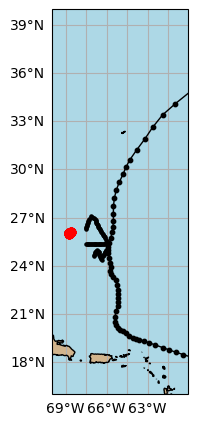

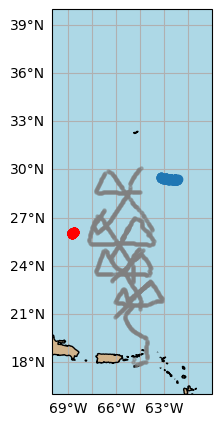

In [75]:
notnull = earl_masked_ds2['spotter_longitude'].notnull()
earl_masked_notnull_ds = earl_masked_ds2.where(notnull)
# earl_masked_ds.sel(time=slice(start_time, end_time))

extent = (-70, -60, 16, 40)  #(<min longitude>, <max longitude>, <min latitude>, <max latitude>)
ax = earl_masked_ds2.where(notnull).wsra.plot(plot_best_track=True, extent=extent)
#TODO: plot colocated buoys and WSRA track.
#TODO: need to fix plotting for PyWSRA
ax.scatter(earl_masked_notnull_ds['spotter_longitude'],
           earl_masked_notnull_ds['spotter_latitude'],
           color='r')

ax = earl_masked_ds.sel(time=slice(start_time, end_time)).wsra.plot(plot_best_track=False, extent=extent, color='grey', alpha=0.5)
ax.scatter(earl_masked_notnull_ds['spotter_longitude'],
           earl_masked_notnull_ds['spotter_latitude'],
           color='r')
ax.scatter(
    earl_drifter_df.loc['SPOT-1257']['longitude'],
    earl_drifter_df.loc['SPOT-1257']['latitude'],
)

In [23]:
ian_masked_ds

<xarray.Dataset>
Dimensions:                                (wavenumber_east: 65,
                                            wavenumber_north: 65,
                                            wavelength: 8, obs: 5, time: 948,
                                            frequency: 32, direction: 361,
                                            300534061800920_frequency: 198)
Coordinates:
  * wavenumber_east                        (wavenumber_east) float32 -0.07854...
  * wavenumber_north                       (wavenumber_north) float32 -0.0785...
  * wavelength                             (wavelength) float32 366.0 ... 91.0
  * obs                                    (obs) timedelta64[ns] -1 days +23:...
  * time                                   (time) datetime64[ns] 2022-09-24T0...
  * frequency                              (frequency) float32 0.0247 ... 0.1397
  * direction                              (direction) float64 0.0 ... 6.283
    time_mask                              (time) float64 1.0 1.0 ... 1.0 1.0
  * 300534061800920_frequency              (300534061800920_frequency) float64 ...
Data variables: (12/43)
    directional_wave_spectrum              (time, wavenumber_east, wavenumber_north) float32 ...
    directional_wave_spectrum_180          (time, wavenumber_east, wavenumber_north) float32 ...
    dominant_to_secondary_partition_angle  (time) float32 nan nan ... nan nan
    dominant_wave_direction                (time) float32 -41.74 nan ... nan
    dominant_wave_height                   (time) float32 3.582 nan ... nan
    dominant_wave_wavelength               (time) float32 90.23 nan ... nan
    ...                                     ...
    300534061800920_longitude              (time) float64 nan nan ... nan nan
    300534061800920_latitude               (time) float64 nan nan ... nan nan
    300534061800920_energy_density         (time, 300534061800920_frequency) object ...
    300534061800920_significant_height     (time) float64 nan nan ... nan nan
    300534061800920_distance               (time) float64 nan nan ... nan nan
    300534061800920_time_difference        (time) timedelta64[ns] NaT ... NaT
Attributes:
    title:                ['WSRA level 4 data']
    history:              ['revision: 1.6; date: 20180816; author: NMS/IPS']
    flight_id:            ['20220924H1', '20220925H1', '20220926H1', '2022092...
    mission_id:           ['0309A IAN', '0809A IAN', '1509A IAN', '2009A IAN'...
    storm_id:             AL092022
    date_created:         ['2022-10-28T16:34:47Z', '2022-10-31T14:53:35Z', '2...
    time_coverage_start:  2022-09-24T08:52:41+00:00
    time_coverage_end:    2022-09-28T12:46:48+00:00
    pywsra_file:          ['WSRA-L4-20220924H1.nc', 'WSRA-L4-20220925H1.nc', ...
    storm_name:           ian

In [86]:
atomic_masked_ds = atomic_masked_ds.wsra.colocate_with_path_ds(
    path_ds = atomic_swift_ds,
    path_coords = ('time', 'lon', 'lat'),
    path_vars =  ['energy', 'sea_surface_wave_significant_height', 'wind_speed'],
    temporal_tolerance = np.timedelta64(30, 'm'),
    spatial_tolerance = 50,  # km,
    prefix='swift',
)

# TODO: note ATOMIC data require transposition of the energy matrix.

/opt/homebrew/Caskroom/miniconda/base/envs/wsra-mss/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


### Store

In [87]:
%%capture

%store earl_masked_ds
%store fiona_masked_ds
%store ian_masked_ds
%store julia_masked_ds
%store idalia_masked_ds
%store lee_masked_ds
%store atomic_masked_ds

%store all_wsra_df
%store atomic_df